# Solve the forward pass with an easy u


# Libraries

In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

%matplotlib notebook

In [2]:
def plot_car_trajectory(simulator,sampling_freq):
    fig,ax = plt.subplots(2,3, figsize=(12, 9))
    
    states_sim = simulator.data['_x'][::sampling_freq]
    time =  simulator.data['_time'][::sampling_freq]
    friction = simulator.data['_tvp'][::sampling_freq,0]
    wind = simulator.data['_tvp'][::sampling_freq,1]
    force = simulator.data['_u'][::sampling_freq]
    
    ax[0,0].plot(time,states_sim[:,1]*3.6)
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Velocity (km/hr)")    
    
    dist = states_sim[:,0]/1000
    ax[0,1].plot(time,dist)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("Distance (km)")     
    ax[1,0].plot(time,friction*(1-exp(-states_sim[:,1])),label = "Rolling")
    

    ax[1,0].plot(time,k1*states_sim[:,1]**2,label = "Aero")
    ax[1,0].plot(time,wind,label = "Wind")
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Drag Components")    
    ax[1,0].legend(loc="upper right")
    
    ax[1,1].plot(time,force)
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Acceleration input")     
    
    total_fuel_burn = np.cumsum(a_0 + a_1*force)/1000
    ax[0,2].plot(time,total_fuel_burn)
    ax[0,2].set_xlabel("Time")
    ax[0,2].set_ylabel("Total Fuel Burn (klitres)")     
    instaneous_milage = (total_fuel_burn[1:] - total_fuel_burn[0:-1]) / (dist[1:] - dist[0:-1])

    ax[1,2].plot(time[1:],instaneous_milage)
    ax[1,2].set_xlabel("Time (secs)")
    ax[1,2].set_ylabel("Instaneous Milage (klitres/km)")     

In [3]:
# Defining the constants

a_0 = 0 # assume that fuel burn and force are 1-1 correlated
a_1 = 1
m = 500 # kg # car is half a ton
k1 = 50/450

model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))

k0 = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
fw = model.set_variable(var_type='_tvp', var_name='wind', shape=(1, 1))
acc = model.set_variable(var_type='_u', var_name='acc', shape=(1,1))

x_next = vertcat(x[1], acc/m - (k0*(1-exp(-x[1])) + k1*x[1]**2)/m - fw/m)
model.set_rhs('x',x_next)
model.setup()

params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['wind'] = 0*np.random.normal(0,10)
    if t_now < 200:
        tvp_template['friction'] = 50
    else:
        tvp_template['friction'] = 50    
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()

simulator.x0 = np.array([0,0])

In [4]:
v_s = np.sqrt(450)
best_u = 50*(1-np.exp(-v_s)) + 50/450*v_s**2

In [5]:
def expert_controller(simulator,target_vel):
    current_distance = simulator.data['_x'][-1,0]
    current_velocity = simulator.data['_x'][-1,1]
    current_force = simulator.data['_u'][-1]
    if current_velocity < target_vel and current_force == 0:
        u0 = best_u*np.ones((1,1))
    elif current_velocity < target_vel and current_force > 0:
        u0 = best_u*np.ones((1,1))
    else: 
        u0 = best_u*np.ones((1,1))
    return u0

In [6]:
u0 = best_u*np.ones((1,1))
simulator.reset_history()
simulator.x0 = np.array([0,0])
for i in range(450):
    simulator.make_step(u0)
    u0 = expert_controller(simulator,v_s)

<IPython.core.display.Javascript object>


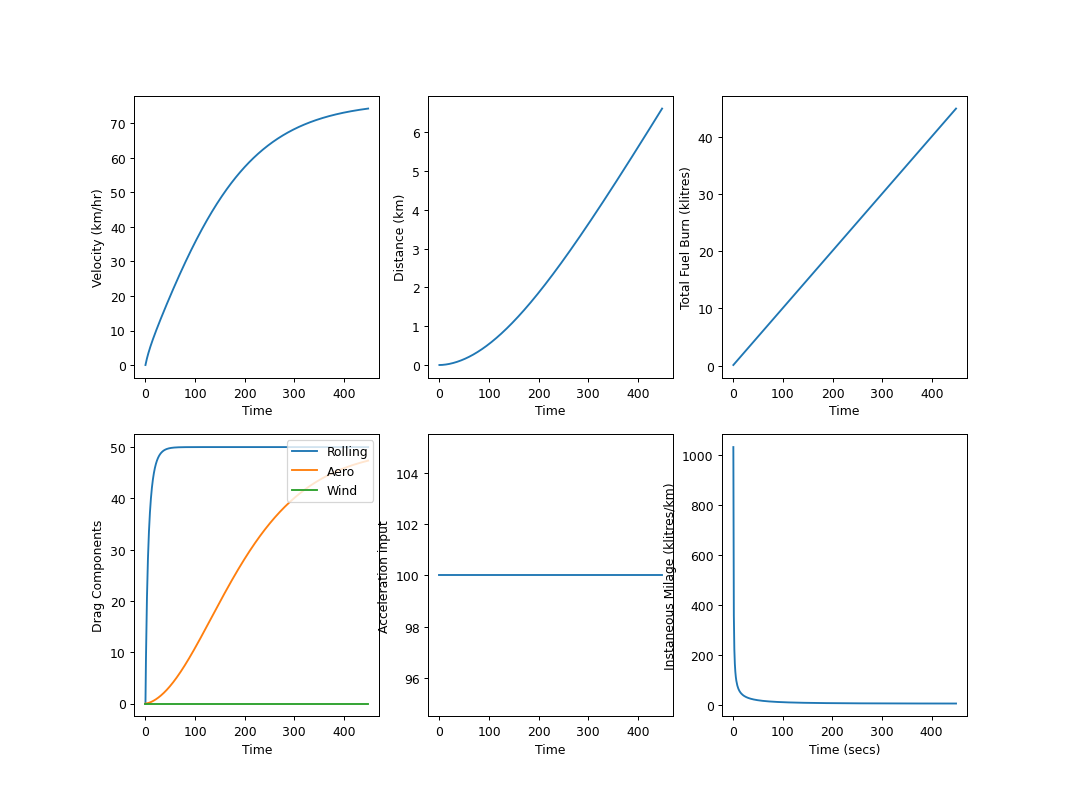

In [7]:
plot_car_trajectory(simulator,sampling_freq = 1)

In [8]:
#print the data
import pandas as pd
data = np.hstack((simulator.data['_time'], simulator.data['_x'],simulator.data['_u'],simulator.data['_tvp']))
df = pd.DataFrame(data, columns = ['time','displacement','velocity','force','friction_0','wind'])
df.to_csv('simple_car.csv')

# Now let's try to measure the friction

In [9]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam

In [10]:
class car_approx(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh(),l1_init = 0.1):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out


In [11]:
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Fapprox = Friction_approximator(2,3)

In [12]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [13]:
# Normalising constants
Mc = 500.0
Tc = 450.0
Vc = 80.0/3.6
Uc = 250.0


def calc_de_loss(nn,rr,t_col_n,un):
    #f(rr,t_col_n)
    de_loss = Mc*Vc/Tc*1*df(nn,t_col_n,1) - (Uc*un - (50*(1-torch.exp(-Vc*f(nn,t_col_n)))+ 50/450*f(nn,t_col_n)*f(nn,t_col_n)*Vc**2 ) ) 
    return de_loss

def calc_bc_loss(nn,rr,t_data_n,vn):
    bc_loss = Vc*(f(nn,t_data_n) - vn)
    return bc_loss

def compute_loss(nn,rr,t_col_n,t_data_n,data_n):
    un = data_n[:,2].view(-1,1)
    vn = data_n[:,1].view(-1,1)
    
    de_loss = calc_de_loss(nn,rr,t_col_n,un)
    bc_loss = calc_bc_loss(nn,rr,t_data_n,vn)

    final_loss = bc_loss.pow(2).mean() + de_loss.pow(2).mean()

    return final_loss,de_loss.pow(2).mean() ,bc_loss.pow(2).mean() 


def optimise(optimiser,nn,rr,t_col_n,t_data_n,data_n):
    optimiser.zero_grad()
    loss,de_loss,bc_loss = compute_loss(nn,rr,t_col_n,t_data_n,data_n)
    loss.backward()
    optimiser.step()
    return loss,de_loss,bc_loss

In [14]:
lr = 0.01
epochs = 10000
PINN = car_approx(3,20)
F_approx = Friction_approximator(2,4)
learnable_params = list(PINN.parameters()) #+ list(F_approx.parameters())
pi_optimizer = Adam(learnable_params, lr=lr)

In [15]:
t_interior = torch.from_numpy(simulator.data['_time']).float()[0:400]
sensor_data = torch.from_numpy(np.hstack((simulator.data['_x'],simulator.data['_u']))).float().div(torch.tensor([[1,Vc,Uc]]))[0:400]
t_interior = t_interior.clone()/Tc

t_collocation =  t_interior.clone()
t_collocation.requires_grad = True

In [16]:
sensor_data.max(0)

torch.return_types.max(
values=tensor([5.5820e+03, 9.1394e-01, 4.0000e-01]),
indices=tensor([399, 399,   0]))

In [17]:
max(t_collocation)

tensor([0.8867], grad_fn=<UnbindBackward0>)

In [18]:
max(t_interior)

tensor([0.8867])

In [19]:
torch.tensor([[1,Vc,Uc]]).size()

torch.Size([1, 3])

<IPython.core.display.Javascript object>


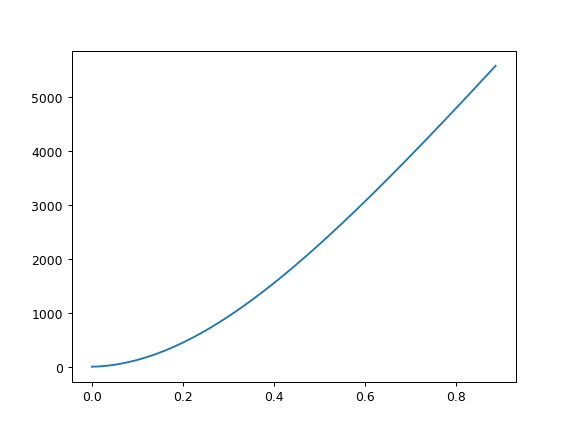

In [20]:
plt.figure()
plt.plot(t_interior,sensor_data[:,0])

In [21]:
#batch_size = 128
#loss_vector = []
#iteration_vector =[]
#for i in range(8000):
#    print(f"Epoch {i}")
#    permutation = torch.randperm(t_interior.size()[0])
#    for j in range(0,t_interior.size()[0],batch_size):
#        indices = permutation[j:j+batch_size]
#        loss,de_loss,bc_loss = optimise(pi_optimizer,PINN,F_approx,t_collocation[indices],t_interior[indices],sensor_data[indices])
#    iteration_vector.append(i)
#    loss_vector.append(loss.detach().numpy())
#    print(loss.detach().numpy(),de_loss.detach().numpy(),bc_loss.detach().numpy())

In [22]:
pi_optimizer = Adam(learnable_params, lr=0.01)
full_loss_vector = []
de_loss_vector = []
bc_loss_vector = []
iteration_vector =[]
for i in range(100000):
    loss,de_loss,bc_loss = optimise(pi_optimizer,PINN,F_approx,t_collocation,t_interior,sensor_data)
    if i % 1000==0:
        iteration_vector.append(i)
        full_loss_vector.append(loss.detach().numpy())
        de_loss_vector.append(de_loss.detach().numpy())
        bc_loss_vector.append(bc_loss.detach().numpy())
        print(i,loss.detach().numpy(),de_loss.detach().numpy(),bc_loss.detach().numpy())

0 435145700.0 435145250.0 434.34973
1000 1092.3928 1057.8823 34.51046
2000 911.57214 880.1739 31.398281
3000 637.472 607.812 29.659971
4000 325.89978 291.4241 34.475693
5000 120.81257 72.61611 48.196457
6000 71.778496 12.286502 59.491993
7000 67.835075 7.7532563 60.08182
8000 65.16511 9.676542 55.488564
9000 62.88375 11.083094 51.800655
10000 59.85817 10.449828 49.40834
11000 54.243843 9.627549 44.616295
12000 42.767296 8.39573 34.371567
13000 24.499935 7.1149054 17.38503
14000 9.478178 5.3232603 4.1549177
15000 2.5353513 1.2940722 1.2412791
16000 1.2983239 0.572006 0.7263178
17000 1.0521662 0.48396915 0.568197
18000 0.90032977 0.40881515 0.49151462
19000 0.7650999 0.32952514 0.4355747
20000 0.64920545 0.26584464 0.38336077
21000 0.55004287 0.22065943 0.32938346
22000 0.45336884 0.1834455 0.26992336
23000 0.34065443 0.14115784 0.1994966
24000 0.20512745 0.08750398 0.11762348
25000 0.1103754 0.05426548 0.056109916
26000 0.2703992 0.20797305 0.062426172
27000 0.06963852 0.03636232 0.0332

<IPython.core.display.Javascript object>


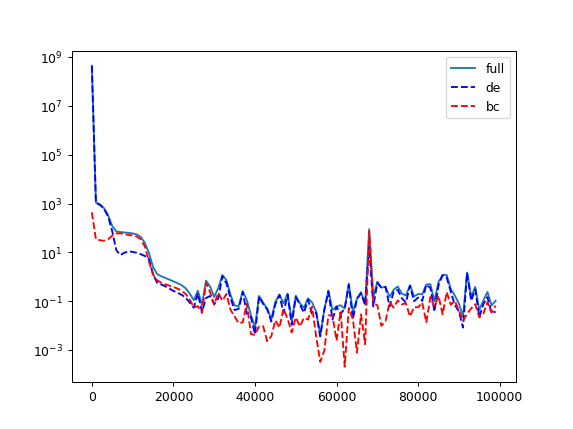

In [23]:
plt.figure()
plt.plot(iteration_vector,full_loss_vector,label = 'full')
plt.plot(iteration_vector,de_loss_vector,'b--',label = 'de')
plt.plot(iteration_vector,bc_loss_vector,'r--',label = 'bc')
plt.yscale('log')
plt.legend()

<IPython.core.display.Javascript object>


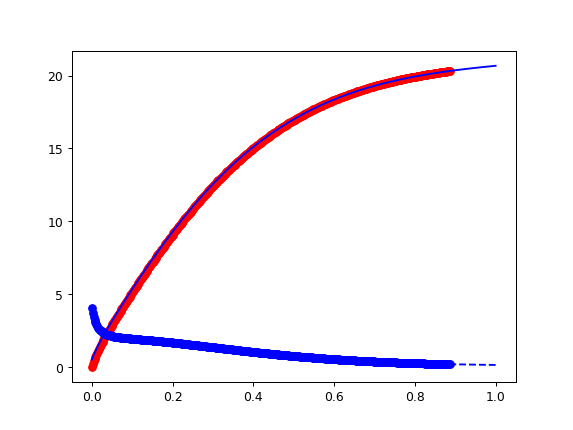

In [24]:
plt.figure()
t_data_domain = torch.linspace(0, 1, steps=1000).view(-1, 1)

with torch.no_grad():
    vel_prediction = PINN(t_data_domain).numpy()
    
t_data_domain.requires_grad = True
acc_prediction = df(PINN,t_data_domain,1).detach().numpy()

vel = sensor_data.detach().numpy()[:,1]*Vc
u = sensor_data.detach().numpy()[:,2]*Uc
acc_actual = (u/m - (50*(1-np.exp(-vel)) + 50/450*vel**2)/m)*Tc/Vc

plt.plot(t_interior.detach().numpy(),sensor_data.detach().numpy()[:,1]*Vc,'or-')
plt.plot(t_data_domain.detach().numpy(),vel_prediction*Vc,'b-')

plt.plot(t_data_domain.detach().numpy(),acc_prediction,'b--')
plt.plot(t_interior.detach().numpy(),acc_actual,'bo')

<IPython.core.display.Javascript object>


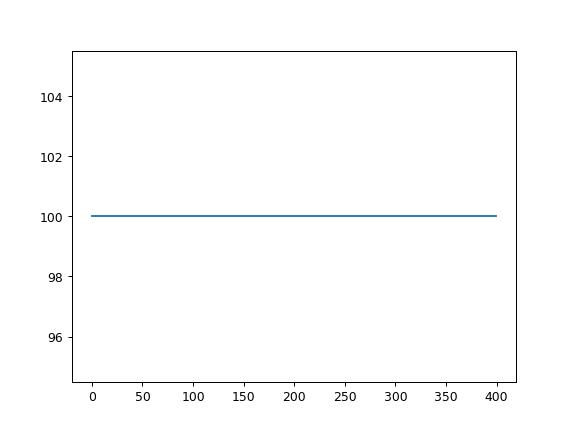

In [25]:
plt.figure()
plt.plot(u)

<IPython.core.display.Javascript object>


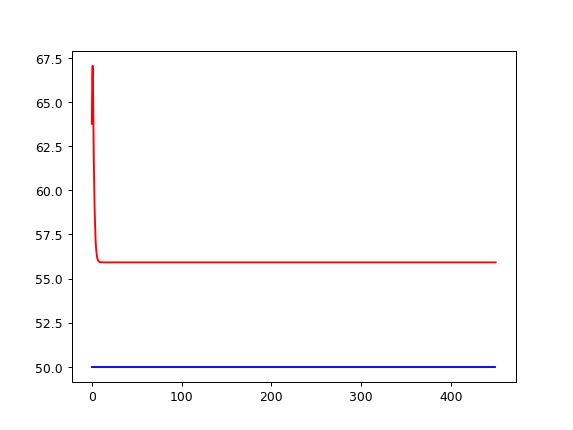

In [26]:
plt.figure()
# NOw interrogate the R approximator
t_data_domain = torch.linspace(0, 450, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = F_approx(t_data_domain).numpy()*100

plt.plot(t_data_domain,r_prediction,'r')
plt.plot(simulator.data['_time'],simulator.data['_tvp'][:,0],'b')

In [27]:
vel_data = sensor_data[:,1].view(-1,1)
u = sensor_data[:,2].view(-1,1)
de_loss = calc_de_loss(PINN,F_approx,t_collocation,u)
bc_loss = calc_bc_loss(PINN,F_approx,t_interior,vel_data)
#ic_loss = calc_ic_loss(PINN,0.0)

<IPython.core.display.Javascript object>


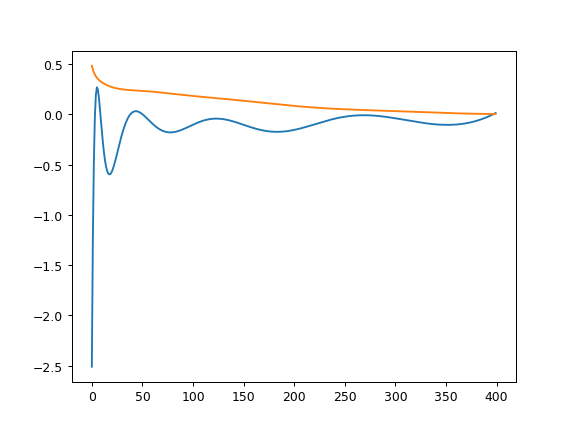

In [28]:
plt.figure()
plt.plot(de_loss.detach().numpy())
plt.plot(bc_loss.detach().numpy())

In [29]:
de_loss.pow(2).detach().numpy().mean()

0.040056814

In [30]:
bc_loss.pow(2).detach().numpy().mean()

0.021799844